In [1]:
import numpy as np
import xarray as xr
# import itertools
import matplotlib.pyplot as plt
# from cartopy import geodesic
# import cartopy.crs as ccrs
# import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import draft_functions as funk
import cmocean.cm as cmo


from scipy import stats


Comparison between simulation using two size classes $k_2$, three size classes $k_3$ or four size classes $k_4$. We are mainly interested how many fragmentation events and how fast the it takes for the particles to reach their maximum size distribution.

In [2]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171§
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = ['_k2', '', '_k4']
sim_names = ['k2', 'k3', 'k4']

In [3]:
# %% Extracting the data from simulation outputs
frag_into_NPs = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000{ft}.zarr'
    sim = xr.open_zarr(local_path)
    nano = sim.where(sim.radius < 1e-6/2, drop=False)
    sim_dict = {}
    print(local_path)
    
    # Find indices of the particles that are not NaN
    aux = np.isnan(nano['radius'].values)
    traj = nano.trajectory.values
    index_MP = np.sum(aux, axis=1)
    index_NP = len(nano.obs) - 1 - np.sum(aux, axis=1)
    sim_dict['particle_index'] = index_NP
    
    # Get depth, latitude, and longitude of NPs
    z = -nano['z'].values
    sim_dict['depths'] = z[(traj, index_NP)]

    latNP = nano['lat'].values
    lonNP = nano['lon'].values

    sim_dict['lat'] = latNP[(traj, index_NP)]
    sim_dict['lon'] = lonNP[(traj, index_NP)]
    sim_dict['time'] = nano['time'].values[(traj, index_NP)]
    sim_dict['radius'] = nano['radius'].values[(traj, index_NP)]
    sim_dict['frag_events'] = nano['frag_events'].values[(traj, index_NP)]

    # Compute displacement of NPs from a reference point (origin)
    xy_pos = (lonNP[(traj, index_NP)], latNP[(traj, index_NP)])
    sim_dict['displacement'] = funk.haversine(origin, xy_pos)

    # Compute histograms of particle counts for each depth bin over time
    zbins = len(depth_bins)-1
    hist_counts = np.zeros((zbins, sim_time))
    t_range = range(0, sim_time, 1)
    
    
    for i, fr in enumerate(tqdm(t_range)):
        x = np.histogram(-nano['z'][:, fr].dropna('trajectory'), bins=depth_bins,
                         density=False)
        hist_counts[:, i] = x[0]

    # Compute total number of particles in each time step
    total_particles = np.sum(hist_counts, axis=0)
    sim_dict['counts'] = total_particles

    p_zt = np.ma.masked_equal(hist_counts, 0) #/total_particles
    # creat a rolling average of h_masked

    sim_dict['vertical_distribution'] = p_zt

    frag_into_NPs[sim_names[k]] = sim_dict
    
    np.save('../data/frag_k2k3k4.npy', frag_into_NPs, allow_pickle=True)


  0%|          | 0/3 [00:00<?, ?it/s]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000_k2.zarr


  0%|          | 0/3 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [4]:
frag_into_NPs = np.load('../data/frag_k2k3k4.npy', allow_pickle=True).item()

In [5]:
surface_events = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000{ft}.zarr'
    sim = xr.open_zarr(local_path)

    # loading fields as np arrays to do some nasty indexing
    radiuses = sim['radius'].values
    depths = sim['z'].values
    latitudes = sim['lat'].values
    longitudes = sim['lon'].values
    frag_events = sim['frag_events'].values

    df_sim = {}  # dictiorany to store data per sim. Could be a pandas DF

    # Detecting the index and the particles that reach the surface
    k1, k2 = np.where(depths < 10)
    idx_particles, idx_k2 = np.unique(k1, return_index=True)
    surface_time = k2[idx_k2]
    
    m1, m2 = np.where(radiuses > 1e-4)
    _, idx_m2 = np.unique(m1, return_index=True)
    time_fragmetation = m2[idx_m2]

    df_sim['particle_index'] = idx_particles
    df_sim['surface_time'] = surface_time  # Days. equivalent to index in simus
    df_sim['radius'] = radiuses[idx_particles, surface_time]
    df_sim['depths'] = depths[idx_particles, surface_time]
    df_sim['frag_events'] = frag_events[idx_particles, surface_time]
    df_sim['frag_time'] = time_fragmetation

    latz = latitudes[idx_particles, surface_time]
    lonz = longitudes[idx_particles, surface_time]
    xy_pos = (lonz, latz)

    df_sim['displacement'] = funk.haversine(origin, xy_pos)
    df_sim['lat'] = latz
    df_sim['lon'] = lonz

    surface_events[sim_names[k]] = df_sim  # Storing the dictionaris in another dict


np.save('../data/surface_events_k2k3k4.npy', surface_events)

100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


## Plot vertical distribution

Plot the ECDF for particle size distribution at the surface, the drift time from the surface, and the number of fragmentation events histograms.

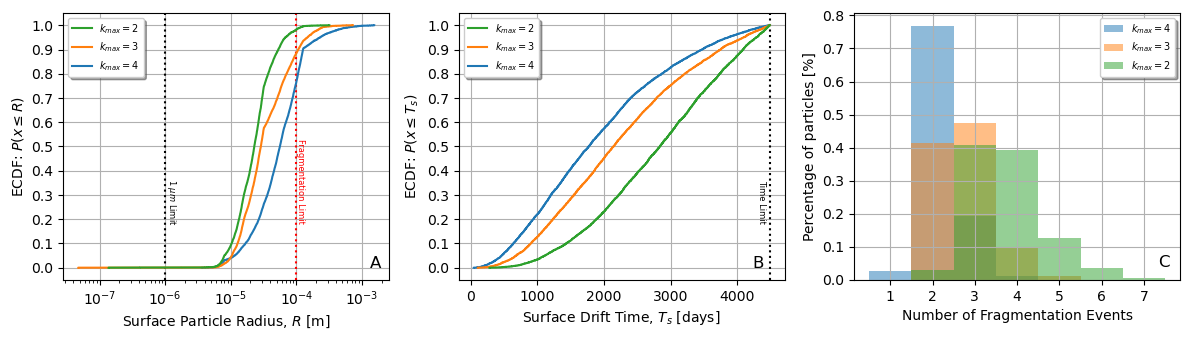

In [32]:
bins = np.linspace(1, 8, 8)
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)

ax[1].axvline(sim_time, ls=':', color='black')
ax[1].text(4300, 0.19, r'Time Limit', fontsize=6, color='k', rotation=-90)

ax[0].axvline(1e-6, ls=':', color='black')
ax[0].axvline(1e-4, ls=':', color='red')
ax[0].text(1e-6, 0.19, r"1 $\mu m$ Limit", fontsize=6, color='k', rotation=-90)
ax[0].text(1e-4, 0.19, r"Fragmentation Limit", fontsize=6, color='red', rotation=-90)

for j, ft in enumerate(sim_names[::-1]):
    
    lbl = r"$k_{max} = $" + r"${}$".format(ft[1])
    x, y = funk.ecdf(surface_events[ft]['radius'], normalized=True)
    ax[0].plot(x, y, drawstyle='steps-post', label=lbl)

    x, y = funk.ecdf(surface_events[ft]['surface_time'], normalized=True)
    ax[1].plot(x, y, drawstyle='steps-post')

    # x, y = funk.ecdf(surface_events[ft]['displacement']/1e3, normalized=True)
    # ax[2].plot(x, y, drawstyle='steps-post')
    ax[2].hist(surface_events[ft]['frag_events'], bins=bins,
               label= lbl, alpha=0.5, align='left',
               density=True)


handles, labels = ax[0].get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

ax[0].legend(handles, labels, fontsize=7, shadow=True)
ax[1].legend(handles, labels, fontsize=7, shadow=True)
ax[2].legend(fontsize=7, shadow=True)
ax[0].semilogx()
ax[0].set_xlabel(r'Surface Particle Radius, $R$ [m]')
ax[0].set_ylabel(r'ECDF: $P(x \leq R)$')

ax[1].set_xlabel(r'Surface Drift Time, $T_s$ [days]')
ax[1].set_ylabel(r'ECDF: $P(x \leq T_s)$')

ax[2].set_xlabel(r'Number of Fragmentation Events')
ax[2].set_ylabel(r'Percentage of particles [%]')

gridy = np.linspace(0, 1, 11)
ax[0].set_yticks(gridy)
ax[1].set_yticks(gridy)
ax[2].set_xticks(bins[:-1])

ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].text(2e-3, 0, r'A', fontsize=12,
               ha='right')
ax[1].text(4400, 0, r'B', fontsize=12,
               ha='right')
ax[2].text(7.6, 0.04, r'C', fontsize=12,
               ha='right')

fig.savefig('../article_figs/k2k3k4_comparison', dpi=300,
            facecolor=(1, 0, 0, 0))

In [29]:
r'$fkmf {}$'.format(ft[1])

'$fkmf 2$'

# Print the %s 

In [29]:
for j, ft in enumerate(sim_names[::-1]):
    
    x, y = funk.ecdf(surface_events[ft]['radius'], normalized=True)
    
    idx_6 = np.where(x>=1e-6)[0][0]
    idx_5 = np.where(x>=1e-5)[0][0]
    idx_4 = np.where(x>=1e-4)[0][0]
    print('-----', ft, '-----')
    print('Radius limit 1e-6: ', y[idx_6])
    print('Radius limit 1e-6 to 1e-5: ', y[idx_5] - y[idx_6])
    print('Radius limit 1e-5 to 1e-4: ', y[idx_4] - y[idx_5])
    print('radiuses > 1e-4: ', 1 - y[idx_4])

----- k4 -----
Radius limit 1e-6:  0.0
Radius limit 1e-6 to 1e-5:  0.040698437705133254
Radius limit 1e-5 to 1e-4:  0.7233819088880137
radiuses > 1e-4:  0.23591965340685306
----- k3 -----
Radius limit 1e-6:  0.0004220002813335209
Radius limit 1e-6 to 1e-5:  0.042200028133352094
Radius limit 1e-5 to 1e-4:  0.8414685609790407
radiuses > 1e-4:  0.11590941060627369
----- k2 -----
Radius limit 1e-6:  0.0010712372790573112
Radius limit 1e-6 to 1e-5:  0.0905195500803428
Radius limit 1e-5 to 1e-4:  0.8903767184431352
radiuses > 1e-4:  0.018032494197464777


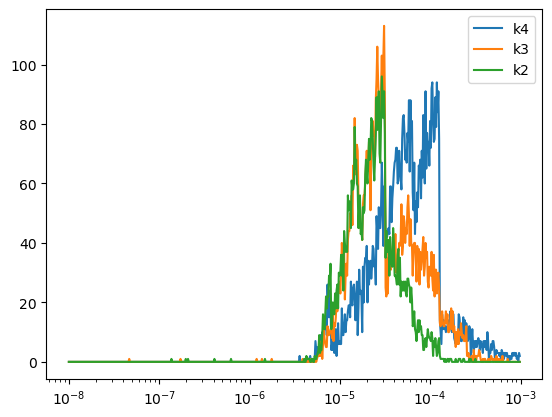

In [65]:
log_bins = np.logspace(-8, -3, 600)
#make a log scale histogram of the radiuses

for j, ft in enumerate(sim_names[::-1]):
    counts, __ = np.histogram(surface_events[ft]['radius'], bins=log_bins, density=False)

    plt.plot(log_bins[:-1], counts, label=ft)
plt.semilogx()
plt.legend()
# plt.hist(surface_events['k4']['radius'], bins=log_bins, label='k4', alpha=0.5, align='left')
